In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

### загружаем данные. применяем различные аугментации для тренировочного и валидационного сета.

сеты разбиты вручную. валидационный = 40% выборки (с одинаковой пропорцией грязных и чистых тарелок)

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r'C:\Users\Dell\Desktop\machine learning\Kaggle\Kaggle_superbowllsh\Superbowl'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### посмотрим 4 элемента тренировочного сета

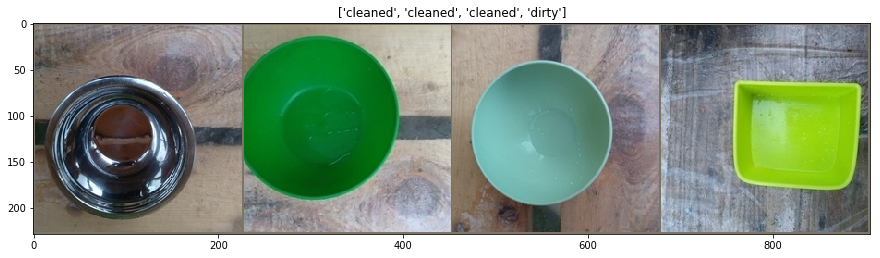

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize = (15,5))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### подготовим функцию для тренировки моделей глубокого обучения

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    step = 5
    
    for epoch in range(num_epochs):
        
        if epoch % step == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if epoch % step == 0:
                
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
                print()

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**[модель №1]** для начала проведем обучение с помощью модели CNN ручной архитектуры (на базе классической модели LeNet)

In [5]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

In [6]:
lenet_model = nn.Sequential(
            nn.Conv2d(3, 224, 5, stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(224),
    
            nn.Conv2d(224, 224, 5, stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d(2), 
            nn.BatchNorm2d(224),
            
            Flattener(),
            nn.Linear(629216, 84),
            nn.Tanh(),

            nn.Linear(84, 10)
          )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.0005, weight_decay=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

model_lenet = train_model(lenet_model, criterion, optimizer,
                         scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 2.7208 Acc: 0.2917

val Loss: 2.1210 Acc: 0.5000

Epoch 5/14
----------
train Loss: 1.1397 Acc: 0.8333

val Loss: 1.1437 Acc: 0.8125

Epoch 10/14
----------
train Loss: 1.1664 Acc: 0.8333

val Loss: 1.1408 Acc: 0.8125

Training complete in 8m 14s
Best val Acc: 0.812500


#### итого получаем достаточно низкую точность на валидационной выборке (только 81.25%). попробуем подходы transfer learning

**[модель №2]** загрузим предобученную модель resnet18 и добавим полносвязный слой FC

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

в процессе тренировки выполнена настройка гиперпараметров

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=60)

Epoch 0/59
----------
train Loss: 0.5360 Acc: 0.6667

val Loss: 0.2812 Acc: 0.9375

Epoch 5/59
----------
train Loss: 0.1427 Acc: 0.9583

val Loss: 0.0262 Acc: 1.0000

Epoch 10/59
----------
train Loss: 0.0230 Acc: 1.0000

val Loss: 0.0182 Acc: 1.0000

Epoch 15/59
----------
train Loss: 0.0552 Acc: 1.0000

val Loss: 0.0156 Acc: 1.0000

Epoch 20/59
----------
train Loss: 0.1585 Acc: 0.9167

val Loss: 0.0150 Acc: 1.0000

Epoch 25/59
----------
train Loss: 0.0761 Acc: 1.0000

val Loss: 0.0140 Acc: 1.0000

Epoch 30/59
----------
train Loss: 0.1699 Acc: 0.9583

val Loss: 0.0142 Acc: 1.0000

Epoch 35/59
----------
train Loss: 0.3783 Acc: 0.8333

val Loss: 0.0156 Acc: 1.0000

Epoch 40/59
----------
train Loss: 0.0461 Acc: 1.0000

val Loss: 0.0157 Acc: 1.0000

Epoch 45/59
----------
train Loss: 0.0244 Acc: 1.0000

val Loss: 0.0173 Acc: 1.0000

Epoch 50/59
----------
train Loss: 0.2321 Acc: 0.9167

val Loss: 0.0161 Acc: 1.0000

Epoch 55/59
----------
train Loss: 0.0139 Acc: 1.0000

val Loss: 0.

**[модель №3]** заморозим веса предобученной модели resnet18 и будет тренировать только финальный FC

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.0005)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8207 Acc: 0.4583

val Loss: 0.7435 Acc: 0.5625

Epoch 5/24
----------
train Loss: 0.4404 Acc: 0.7500

val Loss: 0.5706 Acc: 0.7500

Epoch 10/24
----------
train Loss: 0.5202 Acc: 0.7500

val Loss: 0.5467 Acc: 0.6875

Epoch 15/24
----------
train Loss: 0.5101 Acc: 0.8750

val Loss: 0.5441 Acc: 0.6875

Epoch 20/24
----------
train Loss: 0.4843 Acc: 0.8750

val Loss: 0.5247 Acc: 0.7500

Training complete in 1m 24s
Best val Acc: 0.750000


обращаем внимание, что точность на валидационной выборке гораздо ниже, чем у модели №2

#### загрузим тестовый датасет

In [11]:
data_transforms = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_dir = r'C:\Users\Dell\Desktop\machine learning\Kaggle\Kaggle_superbowllsh\Superbowl\test'
test_dataset = torchvision.datasets.ImageFolder(data_dir, transform=data_transforms)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4)

выбираем **модель №2** для предсказания теста в связи с наилучшей точностью на валидационной выборке и наименьших ошибках на трейне и валидации

In [12]:
final_prediction = []

model = model_ft

for i, (x, y) in enumerate(test_loader):
    prediction = model(x)
    _, indices = torch.max(prediction, 1)
    final_prediction.extend(['cleaned' if x == 0 else 'dirty' for x in indices.tolist()])
    

#### submit

In [13]:
sample_submission = pd.read_csv('sample_submission.csv', dtype = {'id':object})

sample_submission['label'] = final_prediction

sample_submission.to_csv('final_submission.csv', index = False)

далее, выполняем сабмит на платформе kaggle...